## Process Wind Speed

In this notebook, previously prepared 10 m wind speed data is further processed to retrieve yearly and spatially aggregated mean values. The following steps are included:
- Use monthly mean ERA5-Land data that has been cropped to NL / BL forest area
- Calculate yearly mean values for each pixel
- Spatially aggregate wind speed for each federal state to retrieve mean value per state and year

In [1]:
# import libraries
import os
import glob
import xarray as xr
import pandas as pd
import geopandas as gpd
import rasterio
import odc.stac
import pathlib
from pathlib import Path
import warnings

In [2]:
# set working directory
os.chdir("E:/Master/Thesis/3_Data")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: E:\Master\Thesis\3_Data


In [3]:
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [4]:
# create list with forest types
forest_types = ("NL", "BL")

In [ ]:
# loop over years to calculate yearly mean values per pixel

for year in range(1981, 2025):
    
    # process needleleaved and broadleaved forest
    for f in range(len(forest_types)):
        forest_type = forest_types[f]

        # get file of according year that belongs to forest type
        directory = "./Climate/Windspeed/Monthly"
        files = glob.glob(os.path.join(directory, f"*{year}_{forest_type}*.nc"))

        # glob returns a list, we only want the string with the filepath
        file = str(files[0])

        # open netCDF dataset of corresponding year with all monthly datasets
        wind = xr.open_dataset(file, decode_coords="all", decode_times=True, engine = "netcdf4")
        
        # calculate yearly mean values
        wind_year_mean = wind.resample(time="1YS", skipna=True).mean("time")

        # compress data to reduce size
        comp = dict(zlib=True, complevel=4)
        wind_year_mean.wind10m.encoding.update(comp)

        # save created dataset as netCDF4 files
        wind_year_mean.to_netcdf(f"./Climate/Windspeed/Yearly/wind10m_year_mean_{year}_{forest_type}.nc")

In [6]:
# look at exemplary dataset to get an overview
wind_year_mean

<xarray.Dataset> Size: 41MB
Dimensions:      (time: 1, lat: 2952, lon: 3510)
Coordinates:
    spatial_ref  int64 8B ...
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables:
    wind10m      (time, lat, lon) float32 41MB nan nan nan nan ... nan nan nan

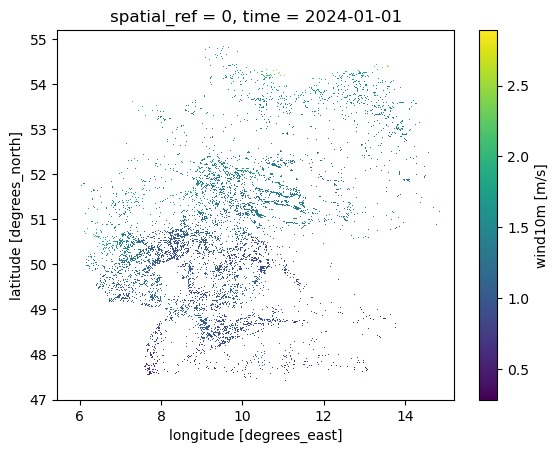

In [7]:
wind_year_mean.wind10m.plot()

In [8]:
# spatially aggregate yearly data
# to get mean values for Germany and federal states

In [9]:
# first, get values for broadleaved forest
# load all yearly wind speed values as one dataset
directory = f"./Climate/Windspeed/Yearly"
filelist = glob.glob(os.path.join(directory, "*BL*.nc"))
wind_yearly = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

In [10]:
# calculate mean values per year for Germany
wind_yearly_spatial_means = wind_yearly.mean(['lon','lat'], skipna=True).to_dataframe()
wind_yearly_spatial_means

,wind10m,spatial_ref
time,,
1981-01-01,1.411595,0
1982-01-01,1.258953,0
1983-01-01,1.498134,0
1984-01-01,1.294369,0
1985-01-01,1.254164,0
1986-01-01,1.466797,0
1987-01-01,1.071700,0
1988-01-01,1.590558,0
1989-01-01,1.257593,0


In [11]:
# drop unneeded columns
wind_yearly_spatial_means = wind_yearly_spatial_means.drop(['spatial_ref'], axis=1)

In [12]:
# rename column with wind value to show area
wind_yearly_spatial_means.rename({"wind10m":"GER"}, axis=1, inplace=True)

In [13]:
# now, calculate yearly mean values for all federal states
# get list of shapefiles of all states
directory = "./Administrative_Borders"
files = list(pathlib.Path(directory).glob('*.shp'))

# loop over filelist to process each state
for f in range(len(files)):
    file = files[f]

    # load state shapefile 
    state = str(file)[23:25]
    state_shp = gpd.read_file(file)

    # reproject shapefile to match netcdf data
    state_shp = state_shp.to_crs(4326)

    # extract one date to create mask of state with dimensions of data
    wind_ex = wind_yearly.sel(time = "1999-01-01", method = "nearest")

    # create mask of research area using the dimensions of the exemplary data
    state_mask = rasterio.features.geometry_mask(state_shp.geometry, 
                                                out_shape=wind_ex.odc.geobox.shape,
                                                transform=wind_ex.odc.geobox.affine,
                                                all_touched=False,
                                                invert=False)
    
    state_mask = xr.DataArray(state_mask, dims=("lat", "lon"))

    # mask yearly data
    wind_state = wind_yearly["wind10m"].where(~state_mask)

    # calculate yearly mean value of state and extract to dataframe
    wind_state_spatial_means = wind_state.mean(['lon','lat'], skipna=True).to_dataframe()

    # drop unneeded columns
    wind_state_spatial_means = wind_state_spatial_means.drop(['spatial_ref'], axis=1)

    # add yearly mean values of state to dataframe
    wind_yearly_spatial_means[state] = wind_state_spatial_means["wind10m"]   

In [14]:
wind_yearly_spatial_means

,GER,BB,BE,BW,BY,HB,HE,HH,MV,NI,NW,RP,SH,SL,SN,ST,TH
time,,,,,,,,,,,,,,,,,
1981-01-01,1.411595,1.491012,1.448815,1.174997,1.145676,1.603489,1.337187,1.559592,1.706256,1.560173,1.712874,1.457662,1.767866,1.346020,1.523060,1.559946,1.486711
1982-01-01,1.258953,1.401387,1.334655,0.950859,0.919803,1.665075,1.190915,1.629728,1.749436,1.480621,1.575386,1.260841,1.883064,1.121284,1.381612,1.391760,1.322957
1983-01-01,1.498134,1.791839,1.730732,1.094082,1.123776,1.838431,1.443853,1.815204,2.057657,1.751895,1.783204,1.484872,2.063819,1.405177,1.706227,1.783296,1.650402
1984-01-01,1.294369,1.485203,1.446879,1.028651,1.023941,1.641391,1.242332,1.577036,1.763396,1.440809,1.556575,1.293359,1.820162,1.200605,1.353804,1.373029,1.325343
1985-01-01,1.254164,1.483484,1.440924,0.976789,0.964681,1.450692,1.151978,1.490841,1.715685,1.442877,1.481545,1.244272,1.700068,1.192847,1.457877,1.514728,1.384224
1986-01-01,1.466797,1.625132,1.565171,1.167992,1.124111,1.812632,1.396487,1.772517,1.954622,1.636512,1.753240,1.520053,2.061686,1.455310,1.530986,1.581036,1.507683
1987-01-01,1.071700,1.228315,1.172127,0.819760,0.837654,1.318459,0.974500,1.326342,1.463652,1.278805,1.335633,1.032253,1.526494,0.865884,1.278863,1.296985,1.158732
1988-01-01,1.590558,1.661242,1.622478,1.274022,1.299499,1.896424,1.541402,1.815091,1.912022,1.811275,1.925800,1.604515,2.007277,1.489462,1.703041,1.771920,1.721638
1989-01-01,1.257593,1.472011,1.408777,0.967121,0.955580,1.583773,1.188437,1.507693,1.731032,1.445546,1.505097,1.223481,1.775620,1.117760,1.454371,1.486963,1.392748


In [15]:
# save as csv dataset
wind_yearly_spatial_means.to_csv("./Tables/Spatial_Means/Windspeed_Yearly_Spatial_Means_BL.csv")

In [16]:
# now take the same steps for needleleaved forest
# load all yearly values as one dataset
directory = f"./Climate/Windspeed/Yearly"
filelist = glob.glob(os.path.join(directory, "*NL*.nc"))
wind_yearly = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

In [17]:
# calculate mean values per year for Germany
wind_yearly_spatial_means = wind_yearly.mean(['lon','lat'], skipna=True).to_dataframe()

In [18]:
# drop unneeded columns
wind_yearly_spatial_means = wind_yearly_spatial_means.drop(['spatial_ref'], axis=1)

In [19]:
# rename column with wind speed value to show area
wind_yearly_spatial_means.rename({"wind10m":"GER"}, axis=1, inplace=True)

In [20]:
# now, calculate yearly mean values for all federal states
# get list of shapefiles of all states
directory = "./Administrative_Borders"
files = list(pathlib.Path(directory).glob('*.shp'))

# loop over filelist to process each state
for f in range(len(files)):
    file = files[f]

    # load state shapefile 
    state = str(file)[23:25]
    state_shp = gpd.read_file(file)

    # reproject shapefile to match netcdf data
    state_shp = state_shp.to_crs(4326)

    # extract one date to create mask of state with dimensions of data
    wind_ex = wind_yearly.sel(time = "1999-01-01", method = "nearest")

    # create mask of research area using the dimensions of the exemplary data
    state_mask = rasterio.features.geometry_mask(state_shp.geometry, 
                                                out_shape=wind_ex.odc.geobox.shape,
                                                transform=wind_ex.odc.geobox.affine,
                                                all_touched=False,
                                                invert=False)
    
    state_mask = xr.DataArray(state_mask, dims=("lat", "lon"))

    # mask yearly data
    wind_state = wind_yearly["wind10m"].where(~state_mask)

    # calculate yearly mean of state and extract to dataframe
    wind_state_spatial_means = wind_state.mean(['lon','lat'], skipna=True).to_dataframe()

    # drop unneeded columns
    wind_state_spatial_means = wind_state_spatial_means.drop(['spatial_ref'], axis=1)

    # add yearly mean values of state to dataframe
    wind_yearly_spatial_means[state] = wind_state_spatial_means["wind10m"]   

In [21]:
wind_yearly_spatial_means

,GER,BB,BE,BW,BY,HB,HE,HH,MV,NI,NW,RP,SH,SL,SN,ST,TH
time,,,,,,,,,,,,,,,,,
1981-01-01,1.361241,1.450269,1.452378,1.144412,1.075158,1.510771,1.331493,1.552982,1.654299,1.552385,1.671792,1.473294,1.651026,1.352017,1.488216,1.479462,1.389824
1982-01-01,1.217579,1.346436,1.333107,0.922879,0.833570,1.540844,1.202990,1.622610,1.652498,1.512370,1.532175,1.264577,1.743216,1.133941,1.375934,1.348092,1.289287
1983-01-01,1.478177,1.731808,1.738804,1.069410,1.033779,1.745904,1.434650,1.807386,1.966204,1.777404,1.731453,1.505687,1.913556,1.414106,1.662701,1.705604,1.545255
1984-01-01,1.269091,1.415779,1.446844,1.007443,0.954299,1.510659,1.237801,1.567710,1.693665,1.476127,1.536700,1.306993,1.672512,1.207752,1.372758,1.357308,1.299663
1985-01-01,1.241336,1.435949,1.443790,0.942003,0.886526,1.366791,1.161640,1.478811,1.647551,1.456396,1.446367,1.270488,1.574820,1.189658,1.428446,1.444577,1.271586
1986-01-01,1.406325,1.553955,1.566743,1.130819,1.018953,1.714119,1.389475,1.762396,1.868799,1.695852,1.710250,1.546473,1.900499,1.458874,1.513266,1.529106,1.433277
1987-01-01,1.073319,1.196097,1.174636,0.812599,0.792135,1.252801,0.969945,1.318630,1.393825,1.281824,1.298575,1.034156,1.412888,0.880497,1.267215,1.235969,1.086728
1988-01-01,1.534847,1.619633,1.626345,1.220200,1.212006,1.804236,1.537653,1.814381,1.855236,1.813822,1.880902,1.623557,1.878259,1.495688,1.678457,1.682485,1.594871
1989-01-01,1.243260,1.421097,1.414857,0.946609,0.908981,1.469276,1.182929,1.497519,1.638250,1.448351,1.454164,1.233893,1.635407,1.122774,1.421717,1.393933,1.308029


In [22]:
# save as csv dataset
wind_yearly_spatial_means.to_csv("./Tables/Spatial_Means/Windspeed_Yearly_Spatial_Means_NL.csv")